# GetAround – Modèle de tarification

Objectif : construire un **modèle de Machine Learning** capable de prédire le
**prix de location par jour** (`rental_price_per_day`) d’un véhicule GetAround,
à partir de ses caractéristiques (kilométrage, puissance, type, options…).

Ce notebook va :
1. Charger et explorer les données de pricing.
2. Préparer les features (numériques / catégorielles).
3. Entraîner et comparer plusieurs modèles :
   - Régression linéaire (baseline)
   - Random Forest Regressor
4. Choisir un modèle final.
5. Sauvegarder le pipeline complet dans `app/api/model.joblib`
   pour l’API FastAPI.

# 1. Imports & chemins

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Gestion des chemins
cwd = Path.cwd()
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd

DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
API_DIR = PROJECT_ROOT / "app" / "api"

DATA_RAW_DIR.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
API_DIR.mkdir(parents=True, exist_ok=True)


## 2. Chargement des données

In [2]:
PRICING_CSV_PATH = DATA_RAW_DIR / "get_around_pricing_project.csv"
PRICING_URL = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv"

if not PRICING_CSV_PATH.exists():
    df_pricing = pd.read_csv(PRICING_URL)
    df_pricing.to_csv(PRICING_CSV_PATH, index=False)
else:
    df_pricing = pd.read_csv(PRICING_CSV_PATH)

print("Shape:", df_pricing.shape)
display(df_pricing.head())
df_pricing.info()

Shape: (4843, 15)


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

## 3. Exploration rapide

On vérifie :
- Les variables disponibles (features numériques / catégorielles)
- La distribution de la cible `rental_price_per_day`
- La présence de valeurs manquantes

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,4843.0,NaN,NaN,NaN,2421.0,1398.198007,0.0,1210.5,2421.0,3631.5,4842.0
model_key,4843,28,Citroën,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,4843.0,NaN,NaN,NaN,140962.799504,60196.740703,-64.0,102913.5,141080.0,175195.5,1000376.0
engine_power,4843.0,NaN,NaN,NaN,128.98823,38.99336,0.0,100.0,120.0,135.0,423.0
fuel,4843,4,diesel,4641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paint_color,4843,10,black,1633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_type,4843,8,estate,1606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
private_parking_available,4843,2,True,2662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gps,4843,2,True,3839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_air_conditioning,4843,2,False,3865,NaN,NaN,NaN,NaN,NaN,NaN,NaN


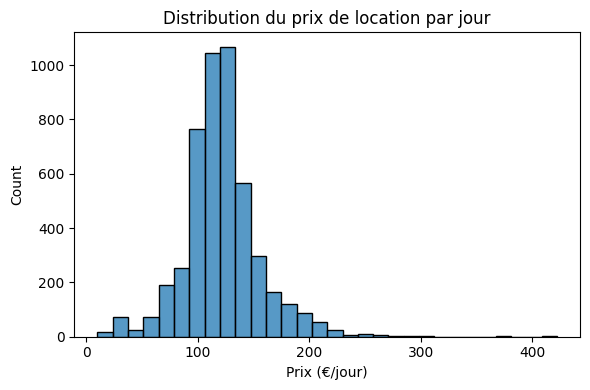

Top colonnes avec valeurs manquantes :


Unnamed: 0                   0.0
model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
dtype: float64

In [3]:
TARGET_COL = "rental_price_per_day"

if TARGET_COL not in df_pricing.columns:
    raise ValueError(f"Target column `{TARGET_COL}` not found in dataset.")

display(df_pricing.describe(include="all").T)

plt.figure(figsize=(6,4))
sns.histplot(df_pricing[TARGET_COL], bins=30)
plt.title("Distribution du prix de location par jour")
plt.xlabel("Prix (€/jour)")
plt.tight_layout()
plt.show()

missing_ratio = df_pricing.isna().mean().sort_values(ascending=False)
print("Top colonnes avec valeurs manquantes :")
display(missing_ratio.head(10))

## 4. Préparation des données

On sépare :
- `y` : la cible (prix/jour)
- `X` : les features

On retire les identifiants (ex : `car_id`) qui n’apportent rien au modèle.

Puis on sépare les colonnes :
- **numériques** : mileage, engine_power, etc.
- **catégorielles** : fuel, paint_color, car_type, …

On construit un **ColumnTransformer** avec :
- Imputation médiane sur les numériques
- Imputation mode + OneHotEncoder sur les catégorielles

In [4]:
# Drop obvious ID cols if present
id_cols = [c for c in ["car_id", "model_key", "Unnamed: 0"] if c in df_pricing.columns]

X = df_pricing.drop(columns=[TARGET_COL] + id_cols)
y = df_pricing[TARGET_COL]

numeric_features = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Numeric features: ['mileage', 'engine_power', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
Categorical features: ['fuel', 'paint_color', 'car_type']


## 5. Split train / test

On garde une partie des données pour évaluer la capacité du modèle
à généraliser à de nouveaux véhicules :
- 80 % train
- 20 % test

In [5]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (3874, 12) Test size: (969, 12)


## 6. Entraînement & comparaison de modèles

On compare deux modèles :

1. **LinearRegression**
   - Simple, interprétable
   - Baseline

2. **RandomForestRegressor**
   - Modèle d’ensemble non linéaire
   - Capture mieux les relations complexes

On utilise trois métriques :

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² (coefficient de détermination)

In [6]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # compatible sklearn
    r2 = r2_score(y_test, y_pred)

    print(f"=== {name} ===")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")
    print()

    return {
        "name": name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "model": model,
        "y_pred": y_pred     
    }

In [7]:
# Pipeline Linear Regression
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Pipeline Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

results = []
results.append(evaluate_model("LinearRegression", lr_pipeline, X_train, X_test, y_train, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_pipeline, X_train, X_test, y_train, y_test)) 

=== LinearRegression ===
MAE  : 13.06
RMSE : 18.82
R²   : 0.664

=== RandomForestRegressor ===
MAE  : 11.46
RMSE : 17.62
R²   : 0.705



In [8]:
results_df = pd.DataFrame([
    {"model": r["name"], "MAE": r["mae"], "RMSE": r["rmse"], "R2": r["r2"]}
    for r in results
])
results_df

,model,MAE,RMSE,R2
0,LinearRegression,13.055386,18.818653,0.663755
1,RandomForestRegressor,11.457967,17.615027,0.705391


> *« On a comparé une régression linéaire (modèle simple) et une Random Forest
> (modèle d’ensemble non linéaire).  
> La Random Forest obtient un **MAE plus faible** et un **R² plus élevé**, ce qui
> signifie qu’elle explique mieux la variabilité du prix et commet moins d’erreurs
> en moyenne. Dans un contexte business où la **précision de la recommandation
> de prix** est importante, on choisit la Random Forest comme **modèle final**. »*

Selected best model: RandomForestRegressor


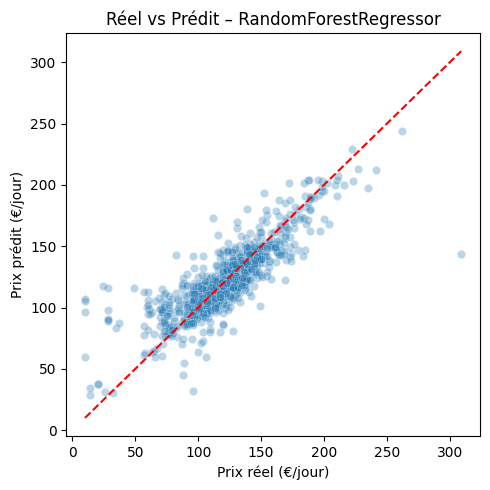

In [9]:
# Visualisation simple des prédictions du meilleur modèle (par R²)
best_result = max(results, key=lambda r: r["r2"])
best_name = best_result["name"]
best_model = best_result["model"]
best_y_pred = best_result["y_pred"]

print(f"Selected best model: {best_name}")

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=best_y_pred, alpha=0.3)
plt.xlabel("Prix réel (€/jour)")
plt.ylabel("Prix prédit (€/jour)")
plt.title(f"Réel vs Prédit – {best_name}")
lims = [min(y_test.min(), best_y_pred.min()), max(y_test.max(), best_y_pred.max())]
plt.plot(lims, lims, "r--")
plt.tight_layout()
plt.show()

## 7. Entraînement final sur toutes les données & sauvegarde du modèle

Une fois le modèle choisi, on le réentraîne sur **toutes les données** (train + test)
pour exploiter au maximum l’information disponible.

On sauvegarde ensuite un **bundle** contenant :
- le pipeline complet (`preprocessor` + `regressor`)
- la liste des colonnes utilisées (`feature_columns`)
- la liste des features numériques / catégorielles (utile pour debug)

Le fichier est stocké dans :

- `app/api/model.joblib`

et sera chargé dans l’API FastAPI.

In [10]:
# Retrain best model on full dataset
best_model.fit(X, y)

model_bundle = {
    "model": best_model,
    "feature_columns": X.columns.tolist(),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
}

MODEL_PATH = API_DIR / "model.joblib"
joblib.dump(model_bundle, MODEL_PATH)

print("Model bundle saved to:", MODEL_PATH)

Model bundle saved to: c:\Users\Balerion\Desktop\getaround_project\app\api\model.joblib


## 8. Format d'entrée pour l'API `/predict`

L’API FastAPI attendra un JSON de la forme :

```json
{
  "input": [
    {
      "mileage": 150000,
      "engine_power": 90,
      "fuel": "diesel",
      "paint_color": "black",
      "car_type": "sedan",
      "private_parking_available": 1,
      "has_gps": 0,
      "has_air_conditioning": 1,
      "automatic_car": 0,
      "has_getaround_connect": 1,
      "has_speed_regulator": 1,
      "winter_tires": 0
    }
  ]
}